In [1]:
import os
import json
import csv
import pandas as pd
import sqlite3 as sql
from collections import namedtuple
import sklearn
import sklearn.linear_model
import numpy as np
import statsmodels.api
import matplotlib.pyplot as plt
from statistics import mean
import seaborn as sns
import sklearn.pipeline
import sklearn.impute
import sklearn.compose
from sklearn.model_selection import train_test_split

In [2]:
teams = pd.read_csv("nfl_teams.csv")
stadiums = pd.read_csv("nfl_stadiums.csv")
scores = pd.read_csv("spreadspoke_scores.csv")
stats = pd.read_csv("nfl_team_stats_2002-2022.csv")

In [3]:
scores

,schedule_date,schedule_season,schedule_week,schedule_playoff,team_home,score_home,score_away,team_away,team_favorite_id,spread_favorite,over_under_line,stadium,stadium_neutral,weather_temperature,weather_wind_mph,weather_humidity,weather_detail
0,9/2/1966,1966,1,False,Miami Dolphins,14,23,Oakland Raiders,NaN,NaN,NaN,Orange Bowl,False,83.0,6.0,71.0,NaN
1,9/3/1966,1966,1,False,Houston Oilers,45,7,Denver Broncos,NaN,NaN,NaN,Rice Stadium,False,81.0,7.0,70.0,NaN
2,9/4/1966,1966,1,False,San Diego Chargers,27,7,Buffalo Bills,NaN,NaN,NaN,Balboa Stadium,False,70.0,7.0,82.0,NaN
3,9/9/1966,1966,2,False,Miami Dolphins,14,19,New York Jets,NaN,NaN,NaN,Orange Bowl,False,82.0,11.0,78.0,NaN
4,9/10/1966,1966,1,False,Green Bay Packers,24,3,Baltimore Colts,NaN,NaN,NaN,Lambeau Field,False,64.0,8.0,62.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13511,1/22/2023,2022,Division,True,Buffalo Bills,10,27,Cincinnati Bengals,BUF,-6.0,48.5,Highmark Stadium,False,32.0,4.0,100.0,snow
13512,1/22/2023,2022,Division,True,San Francisco 49ers,19,12,Dallas Cowboys,SF,-3.5,46.5,Levi's Stadium,False,55.0,19.0,47.0,NaN
13513,1/29/2023,2022,Conference,True,Kansas City Chiefs,23,20,Cincinnati Bengals,KC,-1.5,48,GEHA Field at Arrowhead Stadium,False,22.0,13.0,55.0,NaN
13514,1/29/2023,2022,Conference,True,Philadelphia Eagles,31,7,San Francisco 49ers,PHI,-2.5,45.5,Lincoln Financial Field,False,52.0,14.0,48.0,rain


In [4]:
team_dict = {}
for idx in range(len(teams)):
    current_team = teams.iloc[idx]
    team_dict[current_team["team_name"]] = current_team["team_id"]

In [5]:
team_dict
division_dict = {'Arizona Cardinals': 'NFCW',
 'Atlanta Falcons': 'NFCS',
 'Baltimore Ravens': 'AFCN',
 'Buffalo Bills': 'AFCE',
 'Carolina Panthers': 'NFCS',
 'Chicago Bears': 'NFCN',
 'Cincinnati Bengals': 'AFCN',
 'Cleveland Browns': 'AFCN',
 'Dallas Cowboys': 'NFCE',
 'Denver Broncos': 'AFCW',
 'Detroit Lions': 'NFCN',
 'Green Bay Packers': 'NFCN',
 'Houston Texans': 'AFCS',
 'Indianapolis Colts': 'AFCS',
 'Jacksonville Jaguars': 'AFCS',
 'Kansas City Chiefs': 'AFCW',
 'Las Vegas Raiders': 'AFCW',
 'Los Angeles Chargers': 'AFCW',
 'Los Angeles Rams': 'NFCW',
 'Miami Dolphins': 'AFCE',
 'Minnesota Vikings': 'NFCN',
 'New England Patriots': 'AFCE',
 'New Orleans Saints': 'NFCS',
 'New York Giants': 'NFCE',
 'New York Jets': 'AFCE',
 'Oakland Raiders': 'AFCW',
 'Philadelphia Eagles': 'NFCE',
 'Pittsburgh Steelers': 'AFCN',
 'San Diego Chargers': 'AFCW',
 'San Francisco 49ers': 'NFCW',
 'Seattle Seahawks': 'NFCW',
 'St. Louis Cardinals': 'NFCW',
 'St. Louis Rams': 'NFCW',
 'Tampa Bay Buccaneers': 'NFCS',
 'Tennessee Titans': 'AFCS',
 'Washington Commanders': 'NFCE',
 'Washington Football Team': 'NFCE',
 'Washington Redskins': 'NFCE'}

In [6]:
win_margin_list = []
winner_list = []
winner_id_list = []
for idx in range(len(scores)):
    current_score = scores.iloc[idx]
    if current_score["score_home"] > current_score["score_away"]:
        win_margin_list.append(current_score["score_home"] - current_score["score_away"])
        winner_list.append('HOME')
        winner_id_list.append(team_dict[current_score['team_home']])
    elif current_score["score_home"] == current_score["score_away"]:
        win_margin_list.append(current_score["score_home"] - current_score["score_away"])
        winner_list.append('TIE')
        winner_id_list.append("TIE")
    else:
        win_margin_list.append(current_score["score_away"] - current_score["score_home"])
        winner_list.append('AWAY')
        winner_id_list.append(team_dict[current_score['team_away']])
scores["win_margin"] = win_margin_list
scores['winner'] = winner_list
scores['winner_id'] = winner_id_list

In [7]:
division_list = []
for idx in range(len(scores)):
    current_score = scores.iloc[idx]
    home = current_score["team_home"]
    away = current_score["team_away"]
    if home in division_dict and away in division_dict:
        if division_dict[home] == division_dict[away]:
            division_list.append(True)
        else:
            division_list.append(False)
    else:
        division_list.append(False)
scores["divisional"] = division_list

In [8]:
favorite_list = []
for idx in range(len(scores)):
    current_score = scores.iloc[idx]
    if current_score['team_favorite_id'] == team_dict[current_score['team_home']]:
        favorite_list.append('HOME')
    else:
        favorite_list.append('AWAY')
scores["favorite"] = favorite_list
scores[scores["divisional"] == True][["team_home", "team_away", "divisional"]]

,team_home,team_away,divisional
3,Miami Dolphins,New York Jets,True
9,Detroit Lions,Chicago Bears,True
15,Buffalo Bills,Miami Dolphins,True
17,Dallas Cowboys,New York Giants,True
21,Oakland Raiders,Kansas City Chiefs,True
...,...,...,...
13502,Washington Commanders,Dallas Cowboys,True
13504,San Francisco 49ers,Seattle Seahawks,True
13505,Buffalo Bills,Miami Dolphins,True
13506,Cincinnati Bengals,Baltimore Ravens,True


In [9]:
cover_list = []
cover_margin_list = []
for idx in range(len(scores)):
    current_score = scores.iloc[idx]
    if current_score['winner'] == current_score['favorite']:
        if current_score['win_margin'] > abs(current_score['spread_favorite']):
            cover_list.append("COVER")
            cover_margin_list.append(current_score['win_margin'] - abs(current_score['spread_favorite']))
        elif current_score['win_margin'] == abs(current_score['spread_favorite']):
            cover_list.append("PUSH")
            cover_margin_list.append(0)
        else:
            cover_list.append("NO COVER")
            cover_margin_list.append(current_score['win_margin'] - abs(current_score['spread_favorite']))
    elif current_score['winner'] == "TIE":
        cover_list.append("NO COVER")
        cover_margin_list.append(current_score['win_margin'] - abs(current_score['spread_favorite']))
    else:
        cover_list.append("UPSET")
        cover_margin_list.append(-current_score['win_margin'] - abs(current_score['spread_favorite']))
scores['result'] = cover_list
scores['cover_margin'] = cover_margin_list

In [10]:
cover_result_list = []
for idx in range(len(scores)):
    current_score = scores.iloc[idx]
    if current_score['result'] == "COVER" or current_score['result'] == "PUSH":
        cover_result_list.append("COVER")
    else:
        cover_result_list.append("NO COVER")
        
scores['cover'] = cover_result_list

In [11]:
columns = stats.columns[3:]
stats["penalties_home"] = stats["penalties_home"].str.split('-').str.get(1).astype(int)
stats["penalties_away"] = stats["penalties_away"].str.split('-').str.get(1).astype(int)

In [12]:
scores = scores[scores["schedule_season"] >= 2002]
stats_dict = {}
for index, row in stats.iterrows():
    if int(row["date"][-5:-3]) > 2:
        year = int(row["date"][0:4])
    else:
        year = int(row["date"][0:4]) - 1
    if year < 2023:
        if year not in stats_dict:
            stats_dict[year] = {}
            year_d = stats_dict[year] 
        if row["home"] not in year_d:
            year_d[row["home"]] = {}
        if row["away"] not in year_d:
            year_d[row["away"]] = {}
        home_dict = year_d[row["home"]]
        away_dict = year_d[row["away"]]
        for column in columns:
            if column[:-5] not in home_dict:
                home_dict[column[:-5]] = []
                home_dict[column[:-5]+"_allowed"] = []
            if column[:-5] not in away_dict:
                away_dict[column[:-5]] = []
                away_dict[column[:-5]+"_allowed"] = []
            if column[-4:] == "home":
                home_dict[column[:-5]].append(row[column])
                away_dict[column[:-5]+"_allowed"].append(row[column])
            else:
                away_dict[column[:-5]].append(row[column])
                home_dict[column[:-5]+"_allowed"].append(row[column])

In [13]:
def div(item):
    try:
        return int(item[0]) / int(item[2:])
    except:
        return 0
        

def possession(time):
    return int(time[0:2]) + int(time[3:]) / 60

for year in stats_dict:
    for team in stats_dict[year]:
        for stat in stats_dict[year][team]:
            stat_list = stats_dict[year][team][stat]
            if type(stat_list[0]) == int:
                stats_dict[year][team][stat] = mean(stat_list)
            elif type(stat_list[0]) == str:
                if stat_list[0][2] == ":":
                    stats_dict[year][team][stat] = mean([possession(time) for time in stat_list])
                else:
                    stats_dict[year][team][stat] = mean([div(item) for item in stat_list])
                


In [14]:
df2002 = pd.DataFrame(stats_dict[2022]).transpose()
allowed = [column for column in df2002.columns if "allowed" in column]
own = [column for column in df2002.columns if "allowed" not in column]
df2002_rank_allowed = df2002[allowed].rank(method = "first")
df2002_rank = df2002[own].rank(method = "first", ascending = False)
df2002["penalties"]

Rams          38.529412
Bills         43.444444
Falcons       34.941176
Saints        49.470588
Bears         44.352941
49ers         43.450000
Bengals       39.210526
Steelers      41.823529
Lions         45.470588
Eagles        38.700000
Dolphins      50.833333
Patriots      49.470588
Jets          50.941176
Ravens        39.666667
Commanders    47.352941
Jaguars       39.157895
Panthers      50.705882
Browns        50.882353
Texans        37.882353
Colts         46.705882
Titans        56.294118
Giants        46.157895
Vikings       38.666667
Packers       43.941176
Cardinals     53.882353
Chiefs        46.850000
Chargers      37.611111
Raiders       54.823529
Cowboys       47.736842
Buccaneers    45.944444
Seahawks      49.111111
Broncos       57.058824
Name: penalties, dtype: float64

In [15]:
rank_dict = {}
for year in stats_dict:
    rank_dict[year] = {}
    df = pd.DataFrame(stats_dict[year]).transpose()
    df_rank_allowed = df[allowed].rank(method = "first")
    df_rank = df[own].rank(method = "first", ascending = False)
    df = df_rank.merge(df_rank_allowed, left_index = True, right_on = df_rank.index)
    df = df.drop("key_0", axis = 1)
    for index, row in df.iterrows():
        rank_dict[year][index] = row.to_dict()

In [16]:
rank_dict[2022]["Jets"]

{'first_downs': 26.0,
 'third_downs': 24.0,
 'fourth_downs': 21.0,
 'passing_yards': 15.0,
 'rushing_yards': 25.0,
 'total_yards': 25.0,
 'comp_att': 5.0,
 'sacks': 16.0,
 'rushing_attempts': 27.0,
 'fumbles': 15.0,
 'int': 16.0,
 'turnovers': 12.0,
 'penalties': 5.0,
 'redzone': 32.0,
 'drives': 6.0,
 'def_st_td': 25.0,
 'possession': 31.0,
 'score': 29.0,
 'first_downs_allowed': 3.0,
 'third_downs_allowed': 20.0,
 'fourth_downs_allowed': 14.0,
 'passing_yards_allowed': 3.0,
 'rushing_yards_allowed': 17.0,
 'total_yards_allowed': 4.0,
 'comp_att_allowed': 16.0,
 'sacks_allowed': 24.0,
 'rushing_attempts_allowed': 27.0,
 'fumbles_allowed': 2.0,
 'int_allowed': 14.0,
 'turnovers_allowed': 3.0,
 'penalties_allowed': 6.0,
 'redzone_allowed': 7.0,
 'drives_allowed': 23.0,
 'def_st_td_allowed': 14.0,
 'possession_allowed': 27.0,
 'score_allowed': 2.0}

In [17]:
scores = scores[scores["schedule_season"] >= 2002]

In [18]:
test = scores.iloc[0:2]
test

,schedule_date,schedule_season,schedule_week,schedule_playoff,team_home,score_home,score_away,team_away,team_favorite_id,spread_favorite,...,weather_humidity,weather_detail,win_margin,winner,winner_id,divisional,favorite,result,cover_margin,cover
7872,9/5/2002,2002,1,False,New York Giants,13,16,San Francisco 49ers,SF,-4.0,...,58.0,NaN,3,AWAY,SF,False,AWAY,NO COVER,-1.0,NO COVER
7873,9/8/2002,2002,1,False,Buffalo Bills,31,37,New York Jets,NYJ,-3.0,...,50.0,NaN,6,AWAY,NYJ,True,AWAY,COVER,3.0,COVER


In [19]:
def apply_stats(df, dic):
    stats_list = []
    for index, row in df.iterrows():
        game_dict = {}
        year = row["schedule_season"]
        home = row["team_home"].split()[-1]
        away = row["team_away"].split()[-1]
        home_stat = dic[year][home]
        away_stat = dic[year][away]
        for stat in home_stat:
            game_dict["home_"+stat] = home_stat[stat]
        for stat in away_stat:
            game_dict["away_"+stat] = away_stat[stat]
        stats_list.append(game_dict)
    return pd.DataFrame(stats_list)
        
scores["team_home"] = np.where(scores["team_home"] == "Washington Redskins", "Washington Commanders", scores["team_home"])
scores["team_away"] = np.where(scores["team_away"] == "Washington Redskins", "Washington Commanders", scores["team_away"])
scores["team_home"] = np.where(scores["team_home"] == "Washington Football Team", "Washington Commanders", scores["team_home"])
scores["team_away"] = np.where(scores["team_away"] == "Washington Football Team", "Washington Commanders", scores["team_away"])

In [20]:
rank_df = apply_stats(scores, rank_dict)
rank_df

,home_first_downs,home_third_downs,home_fourth_downs,home_passing_yards,home_rushing_yards,home_total_yards,home_comp_att,home_sacks,home_rushing_attempts,home_fumbles,...,away_rushing_attempts_allowed,away_fumbles_allowed,away_int_allowed,away_turnovers_allowed,away_penalties_allowed,away_redzone_allowed,away_drives_allowed,away_def_st_td_allowed,away_possession_allowed,away_score_allowed
0,9.0,9.0,25.0,4.0,13.0,6.0,28.0,27.0,5.0,20.0,...,10.0,3.0,22.0,13.0,4.0,2.0,8.0,13.0,10.0,24.0
1,3.0,16.0,16.0,5.0,23.0,9.0,24.0,10.0,29.0,8.0,...,12.0,4.0,12.0,6.0,9.0,4.0,5.0,14.0,18.0,9.0
2,30.0,30.0,26.0,30.0,24.0,31.0,1.0,22.0,13.0,3.0,...,21.0,1.0,31.0,24.0,19.0,20.0,20.0,23.0,29.0,17.0
3,28.0,23.0,7.0,24.0,32.0,29.0,12.0,12.0,30.0,7.0,...,5.0,2.0,13.0,5.0,11.0,6.0,22.0,29.0,7.0,30.0
4,14.0,11.0,20.0,15.0,20.0,18.0,22.0,26.0,19.0,17.0,...,11.0,9.0,16.0,14.0,15.0,8.0,12.0,6.0,22.0,21.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5639,3.0,2.0,27.0,5.0,8.0,2.0,12.0,5.0,16.0,3.0,...,7.0,29.0,18.0,25.0,29.0,10.0,13.0,10.0,4.0,5.0
5640,16.0,4.0,30.0,14.0,7.0,5.0,11.0,12.0,9.0,9.0,...,23.0,32.0,23.0,32.0,25.0,3.0,28.0,20.0,22.0,6.0
5641,1.0,3.0,13.0,1.0,20.0,1.0,24.0,30.0,24.0,10.0,...,7.0,29.0,18.0,25.0,29.0,10.0,13.0,10.0,4.0,5.0
5642,2.0,17.0,1.0,9.0,4.0,3.0,18.0,4.0,1.0,13.0,...,3.0,16.0,31.0,30.0,23.0,16.0,11.0,9.0,3.0,1.0


In [21]:
scores = scores.reset_index()
scores = scores.drop(labels = "index", axis = 1)

In [22]:
scores2 = scores.merge(rank_df, left_index = True, right_index = True)

In [23]:
def team_dict(dct):
    team_dict = {}
    for year in dct:
        for team in dct[year]:
            if team not in team_dict:
                team_dict[team] = {}
            team_dict[team][year] = dct[year][team]
    return team_dict
            
team_rank_dict = team_dict(rank_dict)
team_stat_dict = team_dict(stats_dict)

In [24]:
home_favorites = scores2[scores2["favorite"] == "HOME"]
def home_fav(column):
    if "home" in column:
        return column.replace("home", 'fav')
    elif 'away' in column:
        return column.replace('away', 'ud')
    else:
        return column
    
home_favorites.rename(columns=lambda col: home_fav(col), inplace=True)


/var/folders/p_/mfg0jcnn6qb7hvpm95lhwpkh0000gn/T/ipykernel_64586/1916093406.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  home_favorites.rename(columns=lambda col: home_fav(col), inplace=True)


In [25]:
away_favorites = scores2[scores2["favorite"] == "AWAY"]
def away_fav(column):
    if "home" in column:
        return column.replace("home", 'ud')
    elif 'away' in column:
        return column.replace('away', 'fav')
    else:
        return column
    
away_favorites.rename(columns=lambda col: away_fav(col), inplace=True)



/var/folders/p_/mfg0jcnn6qb7hvpm95lhwpkh0000gn/T/ipykernel_64586/3458268848.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  away_favorites.rename(columns=lambda col: away_fav(col), inplace=True)


In [26]:
scores2 = home_favorites.append(away_favorites)
scores2 = scores2.sort_index()

/var/folders/p_/mfg0jcnn6qb7hvpm95lhwpkh0000gn/T/ipykernel_64586/2585563006.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scores2 = home_favorites.append(away_favorites)


In [27]:
scores2.columns[23:25]

Index(['cover_margin', 'cover'], dtype='object')

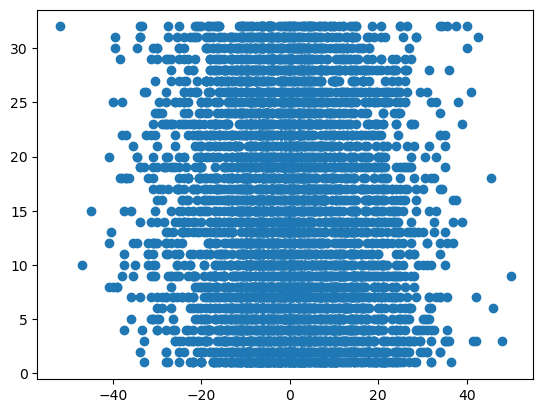

In [28]:
plt.scatter(scores2["cover_margin"], scores2["fav_total_yards_allowed"], )

In [29]:
scores2[:]

,schedule_date,schedule_season,schedule_week,schedule_playoff,team_fav,score_fav,score_ud,team_ud,team_favorite_id,spread_favorite,...,ud_rushing_attempts_allowed,ud_fumbles_allowed,ud_int_allowed,ud_turnovers_allowed,ud_penalties_allowed,ud_redzone_allowed,ud_drives_allowed,ud_def_st_td_allowed,ud_possession_allowed,ud_score_allowed
0,9/5/2002,2002,1,False,San Francisco 49ers,16,13,New York Giants,SF,-4.0,...,7.0,24.0,8.0,9.0,17.0,1.0,13.0,2.0,4.0,3.0
1,9/8/2002,2002,1,False,New York Jets,37,31,Buffalo Bills,NYJ,-3.0,...,23.0,6.0,5.0,1.0,32.0,3.0,15.0,26.0,12.0,27.0
2,9/8/2002,2002,1,False,Baltimore Ravens,7,10,Carolina Panthers,PICK,0.0,...,19.0,26.0,18.0,26.0,8.0,19.0,28.0,20.0,19.0,5.0
3,9/8/2002,2002,1,False,Chicago Bears,27,23,Minnesota Vikings,CHI,-4.5,...,5.0,2.0,13.0,5.0,11.0,6.0,22.0,29.0,7.0,30.0
4,9/8/2002,2002,1,False,Cincinnati Bengals,6,34,San Diego Chargers,CIN,-3.0,...,11.0,9.0,16.0,14.0,15.0,8.0,12.0,6.0,22.0,21.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5639,1/22/2023,2022,Division,True,Buffalo Bills,10,27,Cincinnati Bengals,BUF,-6.0,...,7.0,29.0,18.0,25.0,29.0,10.0,13.0,10.0,4.0,5.0
5640,1/22/2023,2022,Division,True,San Francisco 49ers,19,12,Dallas Cowboys,SF,-3.5,...,23.0,32.0,23.0,32.0,25.0,3.0,28.0,20.0,22.0,6.0
5641,1/29/2023,2022,Conference,True,Kansas City Chiefs,23,20,Cincinnati Bengals,KC,-1.5,...,7.0,29.0,18.0,25.0,29.0,10.0,13.0,10.0,4.0,5.0
5642,1/29/2023,2022,Conference,True,Philadelphia Eagles,31,7,San Francisco 49ers,PHI,-2.5,...,3.0,16.0,31.0,30.0,23.0,16.0,11.0,9.0,3.0,1.0


0.35271409409778964

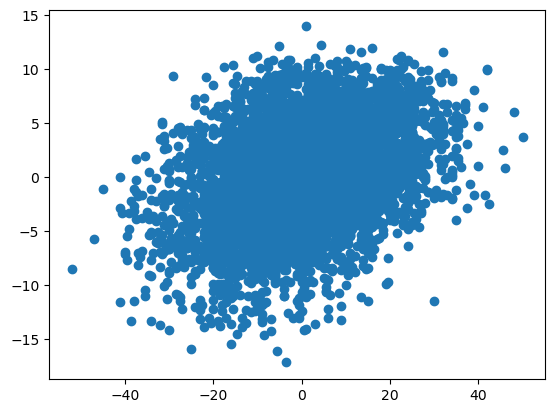

In [30]:
y = scores2["cover_margin"]
x = scores2.iloc[:, 25:]
reg = sklearn.linear_model.LinearRegression()
reg.fit(x, y)
y_pred = reg.predict(x)
y_pred = pd.Series(y_pred)
plt.scatter(y, y_pred)
np.corrcoef(y, y_pred)[0,1]




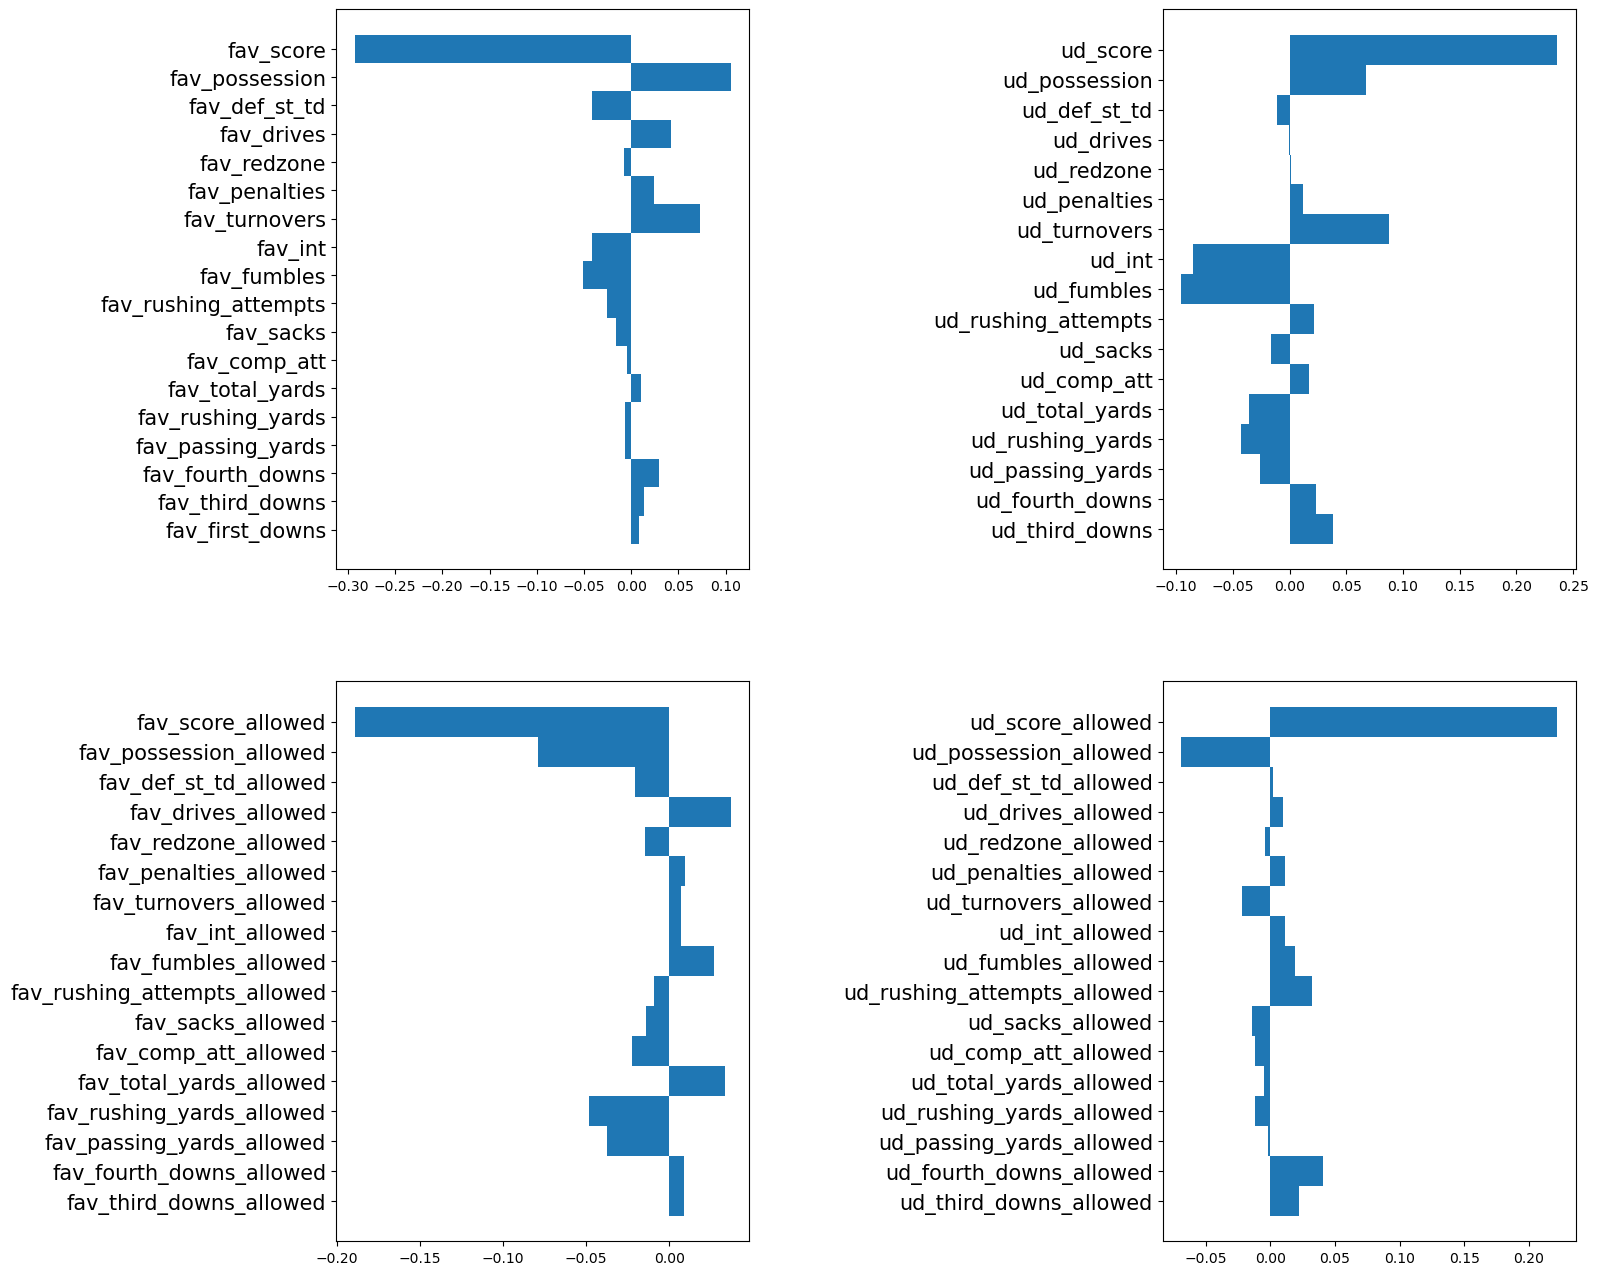

In [31]:
fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (16,16))
plt.subplots_adjust(wspace = 1)
axes[0, 0].barh(x.columns[0:18], reg.coef_[0:18], height = 1)
axes[1, 0].barh(x.columns[19:36], reg.coef_[19:36], height = 1)
axes[0, 1].barh(x.columns[37:54], reg.coef_[37:54], height = 1)
axes[1, 1].barh(x.columns[55:], reg.coef_[55:], height = 1)
axes[0,0].tick_params(axis='y', labelsize = 15)
axes[0,1].tick_params(axis='y', labelsize = 15)
axes[1,0].tick_params(axis='y', labelsize = 15)
axes[1,1].tick_params(axis='y', labelsize = 15)


In [32]:
stat_df = apply_stats(scores, stats_dict)
scores3 = scores.merge(stat_df, left_index = True, right_index = True)
home_favorites = scores3[scores3["favorite"] == "HOME"]    
home_favorites.rename(columns=lambda col: home_fav(col), inplace=True)
away_favorites = scores3[scores3["favorite"] == "AWAY"]    
away_favorites.rename(columns=lambda col: away_fav(col), inplace=True)
scores3 = home_favorites.append(away_favorites)
scores3 = scores3.sort_index()

/var/folders/p_/mfg0jcnn6qb7hvpm95lhwpkh0000gn/T/ipykernel_64586/3112328627.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  home_favorites.rename(columns=lambda col: home_fav(col), inplace=True)
/var/folders/p_/mfg0jcnn6qb7hvpm95lhwpkh0000gn/T/ipykernel_64586/3112328627.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  away_favorites.rename(columns=lambda col: away_fav(col), inplace=True)
/var/folders/p_/mfg0jcnn6qb7hvpm95lhwpkh0000gn/T/ipykernel_64586/3112328627.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scores3 = h

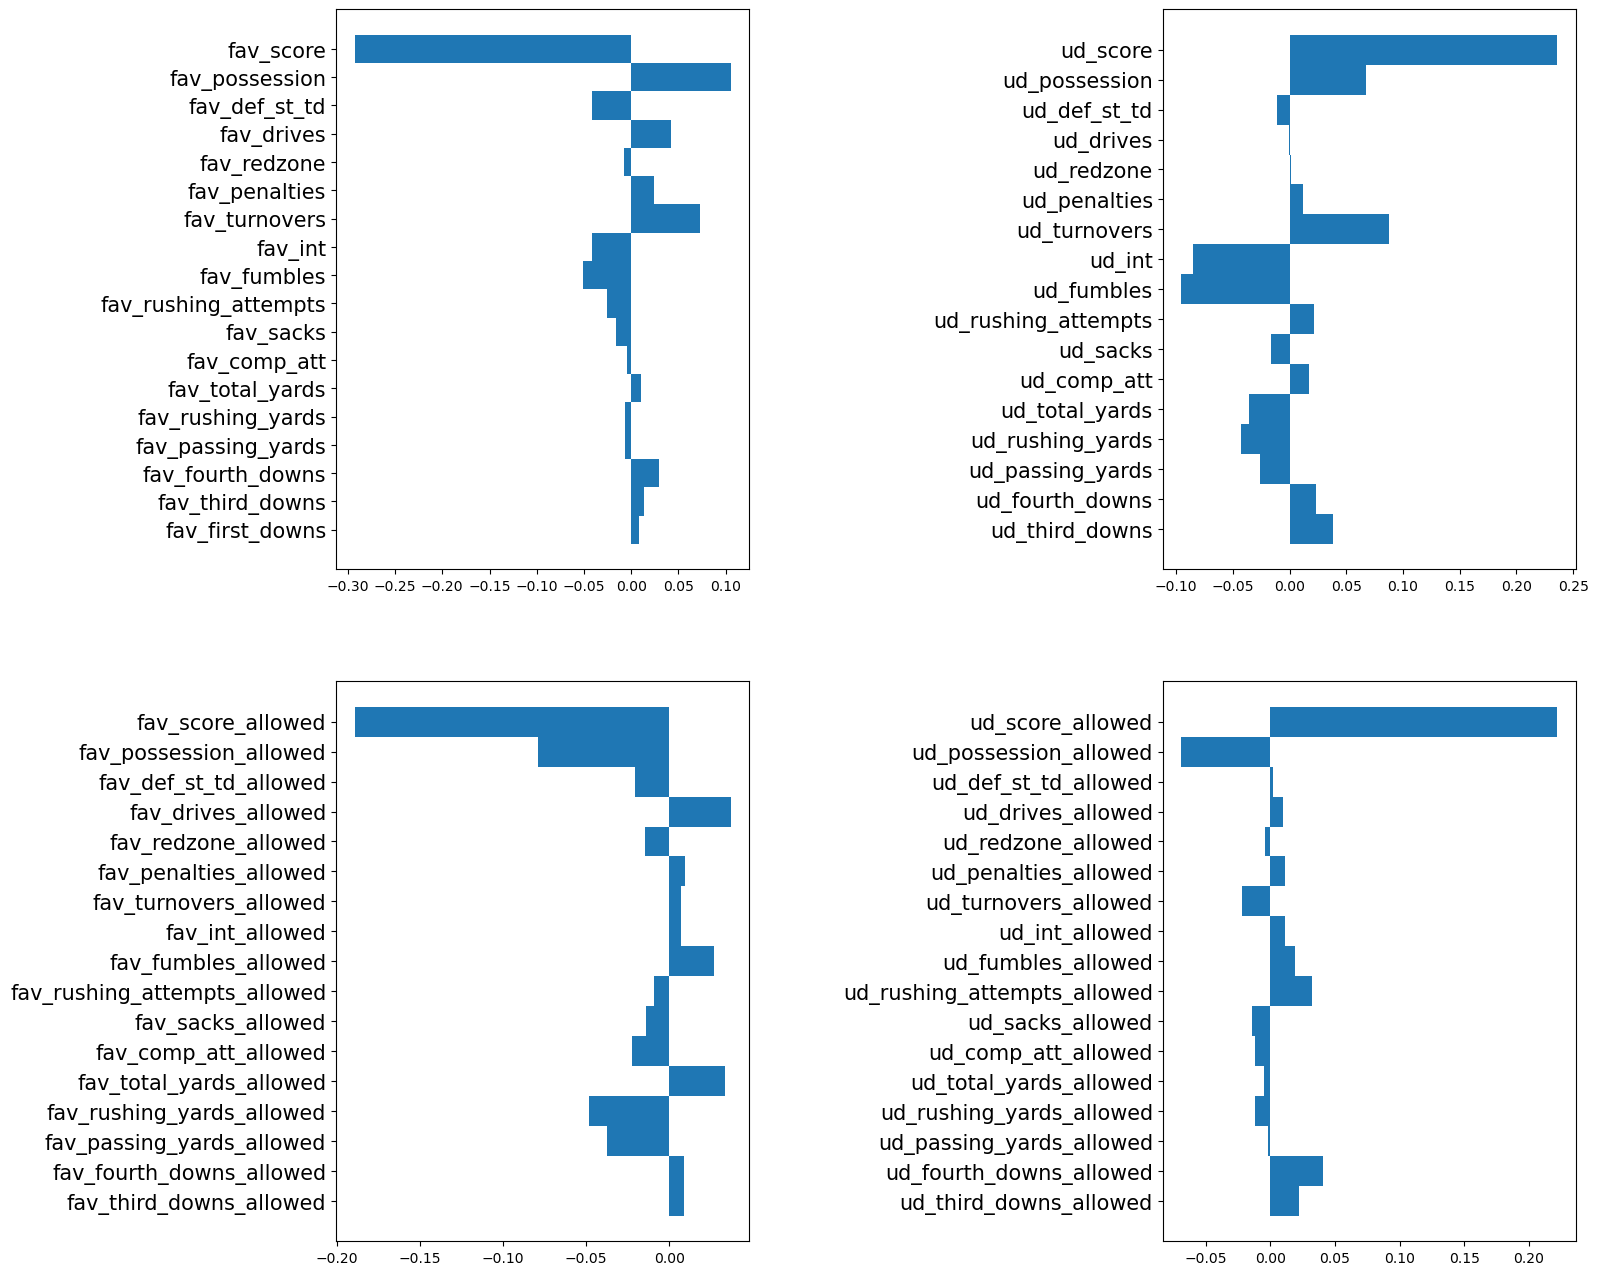

In [33]:
fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (16,16))
plt.subplots_adjust(wspace = 1)
axes[0, 0].barh(x.columns[0:18], reg.coef_[0:18], height = 1)
axes[1, 0].barh(x.columns[19:36], reg.coef_[19:36], height = 1)
axes[0, 1].barh(x.columns[37:54], reg.coef_[37:54], height = 1)
axes[1, 1].barh(x.columns[55:], reg.coef_[55:], height = 1)
axes[0,0].tick_params(axis='y', labelsize = 15)
axes[0,1].tick_params(axis='y', labelsize = 15)
axes[1,0].tick_params(axis='y', labelsize = 15)
axes[1,1].tick_params(axis='y', labelsize = 15)



In [34]:
cont = list(scores3.columns)
cont = cont[12:]
cont2 = cont[12:]
cont = cont[0:4]
cont.extend(cont2)
cont.append("favorite")
cont

['stadium_neutral',
 'weather_temperature',
 'weather_wind_mph',
 'weather_humidity',
 'cover',
 'fav_first_downs',
 'fav_first_downs_allowed',
 'fav_third_downs',
 'fav_third_downs_allowed',
 'fav_fourth_downs',
 'fav_fourth_downs_allowed',
 'fav_passing_yards',
 'fav_passing_yards_allowed',
 'fav_rushing_yards',
 'fav_rushing_yards_allowed',
 'fav_total_yards',
 'fav_total_yards_allowed',
 'fav_comp_att',
 'fav_comp_att_allowed',
 'fav_sacks',
 'fav_sacks_allowed',
 'fav_rushing_attempts',
 'fav_rushing_attempts_allowed',
 'fav_fumbles',
 'fav_fumbles_allowed',
 'fav_int',
 'fav_int_allowed',
 'fav_turnovers',
 'fav_turnovers_allowed',
 'fav_penalties',
 'fav_penalties_allowed',
 'fav_redzone',
 'fav_redzone_allowed',
 'fav_drives',
 'fav_drives_allowed',
 'fav_def_st_td',
 'fav_def_st_td_allowed',
 'fav_possession',
 'fav_possession_allowed',
 'fav_score',
 'fav_score_allowed',
 'ud_first_downs',
 'ud_first_downs_allowed',
 'ud_third_downs',
 'ud_third_downs_allowed',
 'ud_fourth_do

In [35]:
def stat(stat):
    return ["fav_"+stat, "fav_"+stat+"_allowed", "ud_"+stat, "ud_"+stat+"_allowed"]

stat("pheen") + stat("grunt")

['fav_pheen',
 'fav_pheen_allowed',
 'ud_pheen',
 'ud_pheen_allowed',
 'fav_grunt',
 'fav_grunt_allowed',
 'ud_grunt',
 'ud_grunt_allowed']

In [36]:
y2 = scores3["cover"]
x2 = scores3.drop("cover", axis = 1)

continuous = stat("score") + stat("turnovers") + stat("total_yards") + stat("possession")
discrete = ["favorite", "schedule_playoff", "divisional"]
transformer_c2 = sklearn.preprocessing.StandardScaler()
transformer_d = sklearn.preprocessing.OneHotEncoder()
steps_c = sklearn.pipeline.Pipeline(steps = [(("tc2", transformer_c2))])
steps_d = sklearn.pipeline.Pipeline(steps = [(("td", transformer_d))])
pre = sklearn.compose.ColumnTransformer(transformers = [("c", steps_c, continuous), ("d", steps_d, discrete)])
model = sklearn.pipeline.Pipeline(steps = [("pre", pre), ("clf", sklearn.linear_model.LogisticRegression())])
model


Pipeline(steps=[('pre',
                 ColumnTransformer(transformers=[('c',
                                                  Pipeline(steps=[('tc2',
                                                                   StandardScaler())]),
                                                  ['fav_score',
                                                   'fav_score_allowed',
                                                   'ud_score',
                                                   'ud_score_allowed',
                                                   'fav_turnovers',
                                                   'fav_turnovers_allowed',
                                                   'ud_turnovers',
                                                   'ud_turnovers_allowed',
                                                   'fav_total_yards',
                                                   'fav_total_yards_allowed',
                                                   'ud_total_yards',
                                                   'ud_total_yards_allowed',
                                                   'fav_possession',
                                                   'fav_possession_allowed',
                                                   'ud_possession',
                                                   'ud_possession_allowed']),
                                                 ('d',
                                                  Pipeline(steps=[('td',
                                                                   OneHotEncoder())]),
                                                  ['favorite',
                                                   'schedule_playoff',
                                                   'divisional'])])),
                ('clf', LogisticRegression())])

In [37]:
sklearn.model_selection.cross_val_score(model, x2, y2, cv = 5).mean()

0.6119747595625327

In [38]:
model.fit(x2, y2)
y_pred = model.predict(x2)
sklearn.metrics.confusion_matrix(y2, y_pred)

array([[1709, 1106],
       [1074, 1755]])

In [39]:
results = pd.concat([y2.reset_index(), pd.Series(y_pred)], axis = 1)

In [40]:
w = results[results["cover"] != results[0]]
index_filter = list(w.index)
wrong = x2[x2.index.isin(index_filter)]
wrong

,schedule_date,schedule_season,schedule_week,schedule_playoff,team_fav,score_fav,score_ud,team_ud,team_favorite_id,spread_favorite,...,ud_redzone,ud_redzone_allowed,ud_drives,ud_drives_allowed,ud_def_st_td,ud_def_st_td_allowed,ud_possession,ud_possession_allowed,ud_score,ud_score_allowed
12,9/8/2002,2002,1,False,Tampa Bay Buccaneers,20,26,New Orleans Saints,TB,-6.0,...,0.000000,0.000000,15.625000,16.500000,0.562500,0.250000,29.097917,31.662500,27.000000,24.250000
13,9/8/2002,2002,1,False,Tennessee Titans,27,24,Philadelphia Eagles,TEN,-2.0,...,0.000000,0.000000,15.166667,16.833333,0.500000,0.388889,31.104630,29.182407,24.722222,15.222222
14,9/8/2002,2002,1,False,Washington Commanders,31,23,Arizona Cardinals,WAS,-6.0,...,0.000000,0.000000,16.625000,14.562500,0.312500,0.312500,29.163542,31.838542,16.375000,26.062500
16,9/15/2002,2002,2,False,Atlanta Falcons,13,14,Chicago Bears,ATL,-2.5,...,0.000000,0.000000,17.250000,16.125000,0.125000,0.125000,28.063542,32.736458,17.562500,23.687500
20,9/15/2002,2002,2,False,Tennessee Titans,13,21,Dallas Cowboys,TEN,-3.5,...,0.000000,0.000000,16.750000,15.687500,0.500000,0.375000,28.420833,32.318750,13.562500,20.562500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5630,1/8/2023,2022,18,False,Dallas Cowboys,6,26,Washington Commanders,DAL,-7.5,...,0.558824,0.584314,11.588235,11.588235,0.176471,0.117647,33.363725,27.224510,18.882353,20.176471
5633,1/15/2023,2022,Wildcard,True,Buffalo Bills,34,31,Miami Dolphins,BUF,-14.0,...,0.518519,0.612037,10.833333,11.222222,0.222222,0.166667,29.249074,30.750926,23.777778,24.055556
5640,1/22/2023,2022,Division,True,San Francisco 49ers,19,12,Dallas Cowboys,SF,-3.5,...,0.668421,0.435088,11.315789,11.473684,0.157895,0.157895,29.759649,30.768421,26.842105,19.736842
5641,1/29/2023,2022,Conference,True,Kansas City Chiefs,23,20,Cincinnati Bengals,KC,-1.5,...,0.673434,0.509649,10.842105,10.789474,0.105263,0.105263,31.826316,28.700000,25.736842,19.578947


In [41]:
wrong = pd.merge(wrong, w, left_index = True, right_index = True)


In [42]:
wrong["pred"] = wrong[0]
wrong = wrong.drop(0, axis = 1)

In [43]:
gb = wrong.groupby("schedule_season")
total = gb.count().sum()[0]

In [44]:
wrong["divisional"].value_counts()

False    1368
True      812
Name: divisional, dtype: int64

In [45]:
logreg_model = model.named_steps['clf']
coefficients = logreg_model.coef_[0]
coefficients

array([-0.37810306,  0.28901373,  0.21698289, -0.33130384,  0.06357763,
       -0.01399617, -0.06010431,  0.0138323 ,  0.10544997, -0.02370283,
       -0.03224977,  0.18597395,  0.17774136,  0.17207471,  0.22160988,
        0.11961353,  0.11279958, -0.06098773, -0.06925187,  0.12106372,
       -0.01996051,  0.07177236])

In [46]:
test = wrong[(wrong["schedule_season"] == 2021)]
test

,schedule_date,schedule_season,schedule_week,schedule_playoff,team_fav,score_fav,score_ud,team_ud,team_favorite_id,spread_favorite,...,ud_drives_allowed,ud_def_st_td,ud_def_st_td_allowed,ud_possession,ud_possession_allowed,ud_score,ud_score_allowed,index,cover,pred
5077,9/12/2021,2021,1,False,Buffalo Bills,16,23,Pittsburgh Steelers,BUF,-6.5,...,11.500000,0.111111,0.111111,30.003704,31.398148,20.222222,24.444444,5077,NO COVER,COVER
5078,9/12/2021,2021,1,False,Carolina Panthers,19,14,New York Jets,CAR,-5.0,...,11.235294,0.117647,0.000000,27.844118,32.729412,18.235294,29.647059,5078,COVER,NO COVER
5082,9/12/2021,2021,1,False,Seattle Seahawks,28,16,Indianapolis Colts,SEA,-2.5,...,10.823529,0.176471,0.058824,32.061765,28.558824,26.529412,21.470588,5082,COVER,NO COVER
5083,9/12/2021,2021,1,False,Kansas City Chiefs,33,29,Cleveland Browns,KC,-6.0,...,10.705882,0.117647,0.058824,30.801961,29.198039,20.529412,21.823529,5083,NO COVER,COVER
5085,9/12/2021,2021,1,False,New England Patriots,16,17,Miami Dolphins,NE,-2.5,...,11.352941,0.352941,0.058824,30.515686,30.072549,20.058824,21.941176,5085,NO COVER,COVER
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5345,1/9/2022,2021,18,False,Washington Commanders,22,7,New York Giants,WAS,-6.0,...,10.823529,0.058824,0.176471,28.708824,31.591176,15.176471,24.470588,5345,COVER,NO COVER
5347,1/15/2022,2021,Wildcard,True,Buffalo Bills,47,17,New England Patriots,BUF,-4.5,...,10.388889,0.166667,0.277778,30.527778,29.812963,26.611111,19.444444,5347,COVER,NO COVER
5349,1/16/2022,2021,Wildcard,True,Dallas Cowboys,17,23,San Francisco 49ers,DAL,-3.5,...,10.750000,0.150000,0.050000,30.872500,29.940000,24.000000,20.600000,5349,NO COVER,COVER
5352,1/17/2022,2021,Wildcard,True,Los Angeles Rams,34,11,Arizona Cardinals,LAR,-3.5,...,10.444444,0.111111,0.166667,30.862963,29.137037,25.555556,22.222222,5352,COVER,NO COVER


In [47]:
def ats(df):
    ats_dict = {}
    ats_fav_list = []
    ats_ud_list = []
    for index, row in df.iterrows():
        fav = row["team_fav"]
        ud = row["team_ud"]
        year = row["schedule_season"]
        if year not in ats_dict:
            ats_dict[year] = {}
        if fav not in ats_dict[year]:
            ats_dict[year][fav] = []
        if ud not in ats_dict[year]:
            ats_dict[year][ud] = []
        if row["cover"] == "COVER":
            ats_dict[year][fav].append(1)
            ats_dict[year][ud].append(0)
        else:
            ats_dict[year][fav].append(0)
            ats_dict[year][ud].append(1)
        if len(ats_dict[year][fav]) == 1:
            ats_fav_list.append(0)
        else:
            ats_fav_list.append(mean(ats_dict[year][fav][:-1]))
        if len(ats_dict[year][ud]) == 1:
            ats_ud_list.append(0)
        else:
            ats_ud_list.append(mean(ats_dict[year][ud][:-1]))
    return pd.DataFrame({"fav_ats": ats_fav_list, "ud_ats": ats_ud_list})

In [48]:
ats(scores3)

,fav_ats,ud_ats
0,0.000000,0.000000
1,0.000000,0.000000
2,0.000000,0.000000
3,0.000000,0.000000
4,0.000000,0.000000
...,...,...
5639,0.529412,0.764706
5640,0.666667,0.611111
5641,0.388889,0.777778
5642,0.500000,0.684211


In [49]:
test  = pd.merge(test.reset_index(), ats(test), left_index = True, right_index = True)


In [50]:
test[(test["team_fav"] == "Kansas City Chiefs") | (test["team_ud"] == "Kansas City Chiefs")]

,level_0,schedule_date,schedule_season,schedule_week,schedule_playoff,team_fav,score_fav,score_ud,team_ud,team_favorite_id,...,ud_def_st_td_allowed,ud_possession,ud_possession_allowed,ud_score,ud_score_allowed,index,cover,pred,fav_ats,ud_ats
3,5083,9/12/2021,2021,1,False,Kansas City Chiefs,33,29,Cleveland Browns,KC,...,0.058824,30.801961,29.198039,20.529412,21.823529,5083,NO COVER,COVER,0.00,0.000000
11,5113,9/26/2021,2021,3,False,Kansas City Chiefs,24,30,Los Angeles Chargers,KC,...,0.176471,29.505882,31.155882,27.882353,27.000000,5113,NO COVER,COVER,0.00,1.000000
42,5196,11/1/2021,2021,8,False,Kansas City Chiefs,20,17,New York Giants,KC,...,0.176471,28.708824,31.591176,15.176471,24.470588,5196,NO COVER,COVER,0.00,1.000000
55,5231,11/21/2021,2021,11,False,Kansas City Chiefs,19,9,Dallas Cowboys,KC,...,0.111111,30.416667,30.231481,30.388889,21.166667,5231,COVER,NO COVER,0.00,0.500000
69,5261,12/5/2021,2021,13,False,Kansas City Chiefs,22,9,Denver Broncos,KC,...,0.294118,30.805882,29.194118,19.705882,18.941176,5261,COVER,NO COVER,0.25,0.333333
74,5283,12/16/2021,2021,15,False,Kansas City Chiefs,34,28,Los Angeles Chargers,KC,...,0.176471,29.505882,31.155882,27.882353,27.000000,5283,COVER,NO COVER,0.40,0.857143
107,5355,1/23/2022,2021,Division,True,Kansas City Chiefs,42,36,Buffalo Bills,KC,...,0.052632,31.470175,28.989474,29.789474,18.315789,5355,COVER,NO COVER,0.50,0.142857


In [51]:
scores3 = pd.merge(scores3, ats(scores3), left_index = True, right_index = True)
scores3["schedule_week"] = scores3["schedule_week"].astype(str)

In [52]:
for n in scores3.columns:
    print(n)

schedule_date
schedule_season
schedule_week
schedule_playoff
team_fav
score_fav
score_ud
team_ud
team_favorite_id
spread_favorite
over_under_line
stadium
stadium_neutral
weather_temperature
weather_wind_mph
weather_humidity
weather_detail
win_margin
winner
winner_id
divisional
favorite
result
cover_margin
cover
fav_first_downs
fav_first_downs_allowed
fav_third_downs
fav_third_downs_allowed
fav_fourth_downs
fav_fourth_downs_allowed
fav_passing_yards
fav_passing_yards_allowed
fav_rushing_yards
fav_rushing_yards_allowed
fav_total_yards
fav_total_yards_allowed
fav_comp_att
fav_comp_att_allowed
fav_sacks
fav_sacks_allowed
fav_rushing_attempts
fav_rushing_attempts_allowed
fav_fumbles
fav_fumbles_allowed
fav_int
fav_int_allowed
fav_turnovers
fav_turnovers_allowed
fav_penalties
fav_penalties_allowed
fav_redzone
fav_redzone_allowed
fav_drives
fav_drives_allowed
fav_def_st_td
fav_def_st_td_allowed
fav_possession
fav_possession_allowed
fav_score
fav_score_allowed
ud_first_downs
ud_first_downs_all

In [64]:
y2 = scores3["cover"]
x2 = scores3.drop("cover", axis = 1)

cont1 = stat("score") + ["fav_turnovers", "ud_turnovers"] + stat("possession") + stat("total_yards") + ["spread_favorite"]
cont2 = ["fav_ats", "ud_ats"]
discrete = ["divisional", "favorite", "schedule_playoff"]
transformer_c1 = sklearn.preprocessing.PolynomialFeatures(include_bias = False, interaction_only = True)
transformer_c2 = sklearn.preprocessing.StandardScaler()
transformer_d = sklearn.preprocessing.OneHotEncoder()
steps_c1 = sklearn.pipeline.Pipeline(steps = [(("tc2", transformer_c2))])
steps_d = sklearn.pipeline.Pipeline(steps = [(("td", transformer_d))])
steps_c2 = sklearn.pipeline.Pipeline(steps = [("tc2", transformer_c2), ("tc1", transformer_c1)])
pre = sklearn.compose.ColumnTransformer(transformers = [("d", steps_d, discrete), ("c1", steps_c1, cont1), ("c2", steps_c2, cont2)])
model = sklearn.pipeline.Pipeline(steps = [("pre", pre), ("clf", sklearn.linear_model.LogisticRegression())])
model



Pipeline(steps=[('pre',
                 ColumnTransformer(transformers=[('d',
                                                  Pipeline(steps=[('td',
                                                                   OneHotEncoder())]),
                                                  ['divisional', 'favorite',
                                                   'schedule_playoff']),
                                                 ('c1',
                                                  Pipeline(steps=[('tc2',
                                                                   StandardScaler())]),
                                                  ['fav_score',
                                                   'fav_score_allowed',
                                                   'ud_score',
                                                   'ud_score_allowed',
                                                   'fav_turnovers',
                                                   'ud_turnovers',
                                                   'fav_possession',
                                                   'fav_possession_allowed',
                                                   'ud_possession',
                                                   'ud_possession_allowed',
                                                   'fav_total_yards',
                                                   'fav_total_yards_allowed',
                                                   'ud_total_yards',
                                                   'ud_total_yards_allowed',
                                                   'spread_favorite']),
                                                 ('c2',
                                                  Pipeline(steps=[('tc2',
                                                                   StandardScaler()),
                                                                  ('tc1',
                                                                   PolynomialFeatures(include_bias=False,
                                                                                      interaction_only=True))]),
                                                  ['fav_ats', 'ud_ats'])])),
                ('clf', LogisticRegression())])

In [65]:
sklearn.model_selection.cross_val_score(model, x2, y2, cv = 5).mean()

0.6490049563726137

In [66]:
model.fit(x2, y2)
y_pred = model.predict(x2)
sklearn.metrics.confusion_matrix(y2, y_pred)

array([[1870,  945],
       [1015, 1814]])

In [67]:
results = pd.concat([y2.reset_index(), pd.Series(y_pred)], axis = 1)
scores3 = pd.merge(scores3, results, left_index = True, right_index = True)

In [68]:
scores3 = scores3.drop("cover_x", axis = 1)


In [69]:
scores3["cover"] = scores3["cover_y"]
scores3["pred"] = scores3[0]
scores3 = scores3.drop(["cover_y", 0], axis = 1)

In [70]:
correct_list = []
for index, row in scores3.iterrows():
    if row["cover"] == row["pred"]:
        correct_list.append(True)
    else:
        correct_list.append(False)
        
scores3["correct"] = correct_list

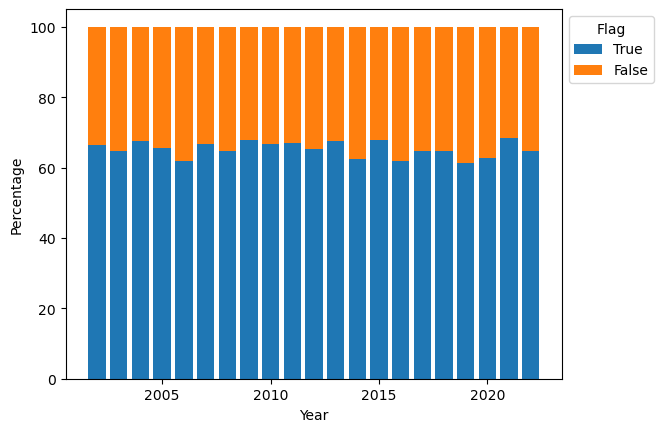

In [71]:

# Count True and False values for each Year and Category
counts = scores3.groupby(['schedule_season', 'correct']).size().unstack(fill_value=0)

percentage = counts.div(counts.sum(axis=1), axis=0) * 100

percentage = pd.DataFrame([percentage.iloc[:,1], percentage.iloc[:, 0]]).transpose()
for correct in percentage.columns:
    plt.bar(percentage.index, percentage[correct], label=correct, bottom=percentage.iloc[:, :percentage.columns.get_loc(correct)].sum(axis=1))
# Add labels and legend
plt.xlabel('Year')
plt.ylabel('Percentage')
plt.legend(title='Flag', bbox_to_anchor=(1, 1))

# Show the plot
plt.show()

In [72]:
 features = discrete + cont1 + cont2

In [73]:
def predict():
    game_dict = {}
    for feature in features:
        game_dict[feature] = input(feature)
    return game_dict

In [89]:
example = {'divisional': False,
 'favorite': 'HOME',
 'schedule_playoff': False,
 'fav_score': '23.9',
 'fav_score_allowed': '20.7',
 'ud_score': '15.7',
 'ud_score_allowed': '22',
 'fav_turnovers': '2.19',
 'ud_turnovers': '2',
 'fav_possession': '1968',
 'fav_possession_allowed': '1692',
 'ud_possession': '1724',
 'ud_possession_allowed': '1936',
 'fav_total_yards': '341.6',
 'fav_total_yards_allowed': '266.56',
 'ud_total_yards': '269.5',
 'ud_total_yards_allowed': '303.13',
 'spread_favorite': '-7.5',
 'fav_ats': '.667',
 'ud_ats': '.4'}

model.predict(pd.DataFrame(pd.Series(example)).transpose())

array(['NO COVER'], dtype=object)

0       False
1        True
2       False
3        True
4       False
        ...  
5639    False
5640    False
5641    False
5642    False
5643    False
Name: divisional, Length: 5644, dtype: bool

In [ ]:
divisionalFalse
favoriteHOME
schedule_playoffFalse
fav_score23.9
fav_score_allowed20.7
ud_score15.7
ud_score_allowed22
fav_turnovers2.19
ud_turnovers2
fav_possession1968
fav_possession_allowed1692
ud_possession1724
ud_possession_allowed1936
fav_total_yards341.6
fav_total_yards_allowed266.56
ud_total_yards269.5
ud_total_yards_allowed303.13
spread_favorite-7.5
